<center><font size = "10"> Week 9 - Long-term plasticity <center>
<center><font size = "8"> Homework - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number:
<br>Group member1:
<br>Group member2:
<br>Group member3:
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

In [1]:
import neuron, time
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

# Recompile external files, load & initialize
!nrnivmodl
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

--No graphics will be displayed.


/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_9-20241116
Mod files: "./VecStim.mod" "./stdp_cc.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


# <font color= 'red'>Ex 1:</font>  Evolution of synaptic conductance in STDP
    
<font size='3'> Let's explore further the changes of synaptic conductance over time in STDP. Go back to tutorial 1 section 3 and set up everything you need to run it. Once you are ready, expand the plot to 3x2, adding the following in the last row:
   - plot the total excitatory synaptic conductance 𝑔𝐸(𝑡) 
   - plot each of the synaptic conductance changes $g_i$ (similar to the $P_i(t)$ plot)


<font size='3'> With the help of these plots, answer the following questions:
   1) In the above, even though all the presynaptic neurons have the same average firing rate, many of the synapses seem to have been weakened? Did you expect that?
   2) Total synaptic conductance is fluctuating over time. How do you expect 𝑔𝐸 to fluctuate if synapses did not show any STDP like behavior?
   3) Do synaptic weights ever reach a stationary state when synapses show STDP?
    
<font size='3'><font color= 'red'>[2 pts]</font>

<span style="color:green">

### **Answer**:
1. Yes. Because
  a. area under the STDP curve is negative
  b. synapses are set to their maximum possible weight.
  c. presynaptic neurons have a variance in their firing rates because of Poisson nature
2. g_E will fluctuate even when synapses do not show any STDP because of the Poisson
nature but with STDP, there will be bigger fluctuations as synaptic weight will
vary on spike by spike basis.
3. Individual synaptic weight will always fluctuate but the synaptic weight
distribution will reach a steady state.
    
### **Grading**: 
- [0.5 pts] for correct plots, with units
- [0.5 pts] for correct answers to each of the questions
    
</span>

In [2]:
# Some functions to help you

# Define parameters of the STDP process
def default_pars_STDP(**kwargs):
    pars = {}
    
    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)
    
    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]
    
    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]
    
    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]
    return pars

def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains
    Args:
        pars            : parameter dictionary
        rate            : noise amplitute [Hz]
        n               : number of Poisson trains
        myseed          : random seed. int or boolean
    Returns:
        pre_spike_train : spike train matrix, ith row represents whether
                          there is a spike in ith spike train over time
                          (1 if spike, 0 otherwise)
    """
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : binary spike train input from
                             presynaptic excitatory neuron
    Returns:
        P                  : LTP ratio
    """
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # Calculate the delta increment dP
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP
    return P

In [3]:
# Function for LIF neuron with STDP synapses

def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    """
    conductance-based LIF dynamics

    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : spike train input from presynaptic excitatory neuron

    Returns:
        rec_spikes         : spike times
        rec_v              : mebrane potential
        gE                 : postsynaptic excitatory conductance
    """

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = generate_P(pars, pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:   # reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref / dt

        # update the synaptic conductance
        M[it + 1] = M[it] - dt / tau_stdp * M[it]
        gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it + 1] < 0
        gE_bar_update[id_temp, it + 1] = 0.

        # calculate the increment of the membrane potential
        dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

        # update membrane potential
        v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

In [4]:
# Figures of the evolution of synaptic conductance
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains

    Args:
        range_t     : time sequence
        spike_train : binary spike trains, with shape (N, Lt)
        n           : number of Poisson trains plot

    Returns:
        Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
        print('The number n exceeds the size of spike trains')
        print('The number n is set to be the size of spike trains')
        n = N

    # Raster plot
    i = 0
    while i <= n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

def make_plot():    
    # Run this cell to see the figures!
    plt.figure(figsize=(12, 8))
    plt.subplot(321)
    dt, range_t = pars['dt'], pars['range_t']
    if rec_spikes.size:
        sp_num = (rec_spikes / dt).astype(int) - 1
        v[sp_num] += 10   # add artificial spikes
    plt.plot(pars['range_t'], v, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')

    plt.subplot(322)
    # Plot the sample presynaptic spike trains
    my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)

    plt.subplot(323)
    plt.plot(pars['range_t'], M, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('M')

    plt.subplot(324)
    for i in range(10):
        plt.plot(pars['range_t'], P[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('P')

    plt.subplot(325)
    for i in range(10):
        plt.plot(pars['range_t'], gE_bar_update[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$\bar g$')

    plt.subplot(326)
    plt.plot(pars['range_t'], gE, 'r')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$g_E$')

    plt.tight_layout()
    plt.show()

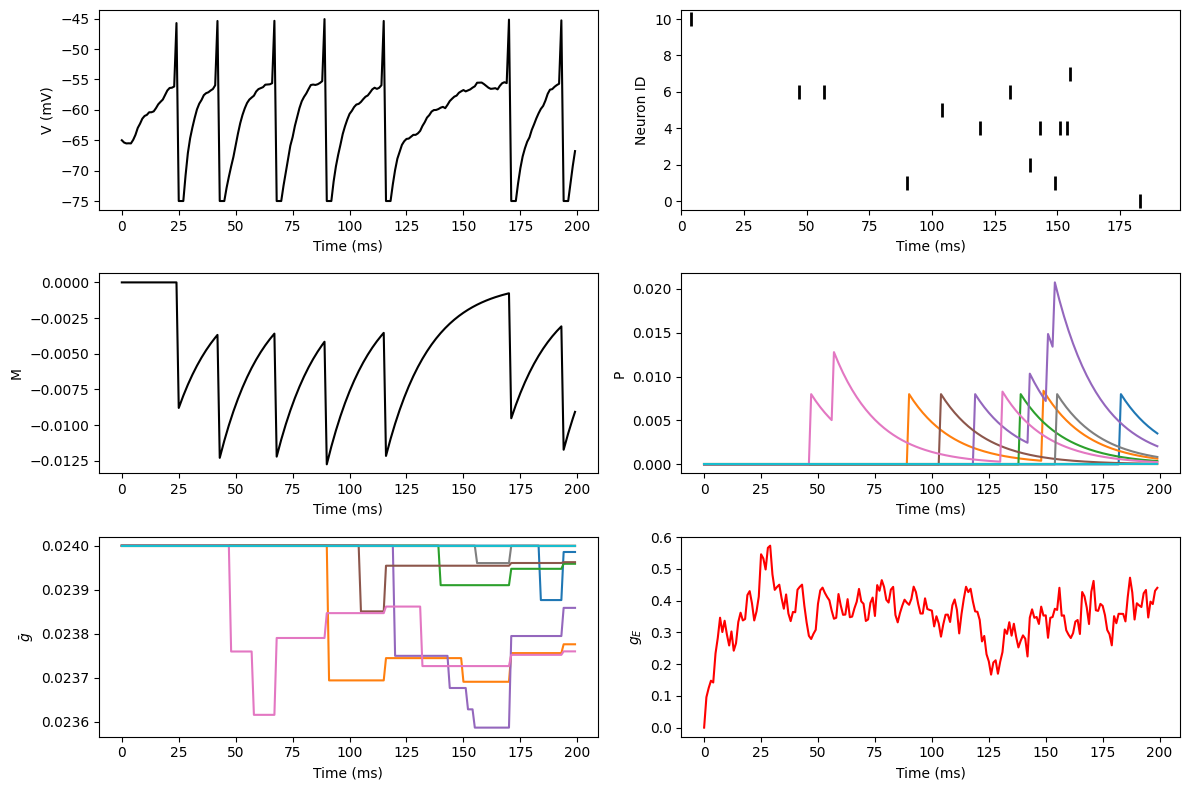

In [5]:
pars = default_pars_STDP(T=200., dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024                   # max synaptic conductance
pars['gE_init'] = 0.024                  # initial synaptic conductance
pars['VE'] = 0.                          # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)

# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,pre_spike_train_ex)
make_plot()

# <font color='red'>Ex 2:</font> Evolution of synaptic weights and STDP conditions

<font size='3'> Use the widget at the end of tutorial to explore how synaptic weights change over time and given different conditions:
   1) Increase the firing rate (i.e., 30 Hz) of presynaptic neurons, and investigate the effect on the dynamics of synaptic weight distribution
   2) Decrease the population size of presynaptic neurons, what do you observe? What happens if you increase it?
   3) What happens if you increase the EPSP time constant? How do you explain this?
   4) And if you decrease it to 4ms? What is the simple, smallest change you can make to rescue the phenomenon? Can you find another, equivalent change that also does the same? Does this make sense with the previous answers?

<font color= 'red'>[2 pts]</font>

<span style="color:green">

### **Answer**:
1. As we increase the input firing rate, more synapses move to the extreme values,
either go to zero or to maximal conductance. Using 15Hz, the distribution of the
weights at the end of the simulation is more like a bell-shaped, skewed, with more
synapses to be potentiated. However, increasing the firing rate, in early times,
almost all synapses undergo depression, and then only a few escape and they become
potentiated.
2. A similar effect as before, since we are using a Poisson distribution for our spike trains, having more neurons or a higher input rate both increase the chance of simultaneous events
3. A similar effect: having a longer time constant increases the window in which two spike events are able to interact and produce STDP
4. Just narrowing the window slightly with tau_syn_E = 4ms results in almost no STDP. But it is sufficient to increase the input rate very slightly (17 Hz) to see some STDP again. You can achieve the same increasing population size (n=400), which is exactly what we saw in the previous answers and makes sense if you think about the chance of interactions based on possible time windows, input rate and number of connected neurons.
    
### **Grading**: 
- [0.5 pts] for each correct answer
    
</span>

In [16]:
# Figure Settings
import ipywidgets as widgets       # interactive display
my_layout = widgets.Layout()

# Functions for simulating a LIF neuron with STDP synapses
def example_LIF_STDP(inputrate=15, Tsim=120000, pop_size=300, tau_e=5):
    """ Simulation of a LIF model with STDP synapses
    Args:
        intputrate  :  The rate used for generate presynaptic spike trains
        Tsim        :  Total simulation time
    output:
        Interactive demo, Visualization of synaptic weights
    """
    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar'] = 0.024
    pars['gE_init'] = 0.014     # initial synaptic conductance
    pars['VE'] = 0.             # [mV]
    pars['tau_syn_E'] = tau_e   # [ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=inputrate, n=pop_size, myseed=2020)  # generate Poisson trains
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)  # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar']  # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime) / 60.
    
    my_layout.width = '620px'
    @widgets.interact(sample_time=widgets.FloatSlider(0.5, min=0., max=1., step=0.1,layout=my_layout))

    def my_visual_STDP_distribution(sample_time=0.0):
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time * (sample_time > 0)

        plt.figure(figsize=(8, 8))
        ax1 = plt.subplot(211)
        for i in range(50):
            ax1.plot(pars['range_t'][::1000] / 1000., gE_bar_update[i, ::1000], lw=1., alpha=0.7)

        ax1.axvline(1e-3 * pars['range_t'][sample_time], 0., 1., color='k', ls='--')
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')

        bins = np.arange(-.05, 1.05, .05)
        g_dis, _ = np.histogram(gbar_norm[:, sample_time], bins)
        ax2 = plt.subplot(212)
        ax2.bar(bins[1:], g_dis, color='g', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s' % (1e-3 * pars['range_t'][sample_time])),fontweight='bold')
        plt.tight_layout()
        plt.show()

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [7]:
example_LIF_STDP(inputrate=15, tau_e=12)

interactive(children=(FloatSlider(value=0.5, description='sample_time', layout=Layout(width='620px'), max=1.0)…

In [8]:
example_LIF_STDP(inputrate=15, tau_e=4, pop_size=400)

interactive(children=(FloatSlider(value=0.5, description='sample_time', layout=Layout(width='620px'), max=1.0)…

# <font color='red'>Ex 3:</font> Voltage-dependent plasticity model

The clopath et al. model can explain the dependence of not just timing but also frequency on plasticity.

Simulate the model as in tutorial 2 and vary both the spike timing and frequency of stimulation. 
Use $\Delta t$ values -10, -7, -5, 5, 7, 10 ms and frequency values 2, 5, 10, 20, 40 Hz.
Plot the STDP curves for different frequencies on the same axis (allowing you to compare)

1. What is the effect of frequency on LTD and on LTP?
2. How does this effect result from the model?

<font color='red'> [2 pts]

<span style="color:green">

 
0.75 pts for running the simulations correctly and 0.25 for visualizing the results corrctly.
1. 0.5 pts for accurately reporting the effects. Assuming they ran the simulations as asked they should see that higher frequencies make the plasticity more potentiating. LTP becomes more pronounced and LTD less. At very high frequency you even see LTP at -10 ms timing. If they realize that at 40 Hz this is equivalent to +15ms delta t (as spikes are 25ms apart) you can give them an extra 0.25 points if they were missing them elsewhere, not exceeding the total of 6 for the set of exercises as a whole.

2. 0.5 pts: The gist of the answer is that at higher frequencies the voltage and low pass filtered values at the synapse spend more time above the potentiation threshold. This means that the LTP process will be active more often. Consider giving them an extra 0.25 if they use additional figures or diagrams to explain this, again not exceeding 6.0 for the whole notebook.
    

</span>

In [9]:
!nrnivmodl

/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_9-20241116
Mod files: "./VecStim.mod" "./stdp_cc.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


In [10]:
# First call all the useful packages
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

In [11]:
DG = r'$\Delta \\bar{g} (% initial)'
FREQUENCY = r'frequency (Hz)'
DT = r'$\Delta t (ms)$'

In [12]:
h.load_file("stdrun.hoc")
def ball_and_stick():
    soma = h.Section(name='soma')
    soma.diam = 20
    soma.L = 20
    apical = h.Section(name='apical')
    apical.diam = 2
    apical.L = 400
    apical.Ra = 240
    apical.nseg=21
    apical.connect(soma(1))

    apical.insert('pas')
    apical.insert('hh')
    soma.insert('hh')
    soma.insert('pas')

        
    return soma, apical


soma, apical = ball_and_stick()
h.topology()


|-|       soma(0-1)
   `--------------------|       apical(0-1)



1.0

In [13]:
def ccsynapse(segment):
    syn = h.STDPSynCC(segment)
    # depression threshold should be same as resting potential to reproduce LTD
    syn.tetam = segment.pas.e
    syn.tau_0 = 6
    syn.tau_y = 5
    syn.A_m = 14e-5
    syn.A_p = 8e-5
    syn.gbar = 0.05
    return syn


In [14]:
def STDP_simulation(
    soma,
    synapse,
    frequency=10, # Hz
    spike_offset=5, # ms
    interstimulus_interval=500, # ms
    nrepetitions=10,
    spikes_per_repetition=5,
    stim_amplitude=1, # nA
    stim_dur=1, # ms
    plot=True,
    view_closely=False
):
    """
    Simulate a STDP protocol with the provided soma and synapse.
    
    Run a protocol in which the synapse and soma are stimulated within a set window of each other.
    Plot a timeseries of the protocol and return the percent change in synaptic conductance.
    
    Arguments:
       soma: neuron section to treat as the soma.
       synapse: synapse object to stimulate.
       frequency: frequency of pre-post spike pairs during each repetition (in Hz).
       interstimulus_interval: interval between stimulation repetitions in ms.
       nrepetitions: number of repetitions of the protocol.
       spikes_per_repeition: number of pre and post spike pairs in each repeition.
       stim_amplitude: current for postsynaptic stimulus in nA.
       stim_dur: duration of postsynaptic stimulus in ms. 
           Current and duration should be sufficient to cause AP firing
       plot: whether or not to plot timeseries (default True)
       view_closely: whether to zoom in on the first spike for the plot
    """
    pre_stim_list = []
    post_stim = []
    t = 0
    for repetition in range(nrepetitions):
        t += interstimulus_interval
        for spike in range(spikes_per_repetition):
            pre_stim_list.append(t)
            post = h.IClamp(soma(0.5))
            post.delay = t + spike_offset
            post.amp = stim_amplitude
            post.dur = stim_dur
            post_stim.append(post)
            t += 1000 / frequency
            

    pre_stim = h.VecStim()
    t_stim_vec = h.Vector(pre_stim_list)
    pre_stim.play(t_stim_vec, None)
    connection = h.NetCon(pre_stim, synapse)
    connection.delay = 0
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    rec_g = h.Vector()
    rec_g.record(synapse._ref_g)
    rec_gbar = h.Vector()
    rec_gbar.record(synapse._ref_gbar)
    rec_i = h.Vector()
    rec_i.record(synapse._ref_i)
    rec_r = h.Vector()
    rec_r.record(synapse._ref_r)
    
    rec_um1 = h.Vector()
    rec_um1.record(synapse._ref_u_m1)
    rec_um2 = h.Vector()
    rec_um2.record(synapse._ref_u_m2)

    h.finitialize(-70)

    h.continuerun(t)

    
    time = np.array(rec_t)
    potential = np.array(rec_v)
    conductance = np.array(rec_g)
    current = np.array(rec_i)
    gbar = np.array(rec_gbar)
    spike_trace = np.array(rec_r)

    if plot:
        f, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
        axes[0].plot(time, potential, label='$V_m$')
        axes[0].vlines(np.array(pre_stim_list) + connection.delay, ymin=-70, ymax=20, color='k', label='pre_spikes')
        axes[0].hlines(synapse.tetam, label='$\\theta_{-}$', color='gray', xmin=time.min(), xmax=time.max())
        axes[0].hlines(synapse.tetap, label='$\\theta_{+}$', color='gray', xmin=time.min(), xmax=time.max())

        axes[0].vlines([post.delay for post in post_stim], ymin=-70, ymax=20, color='cyan', label='post_stims')

        axes[0].plot(time, rec_um1, label='$u_{-}$')
        axes[0].plot(time, rec_um2, label='$u_{+}$')
        
        def scale_secondary(values):
            return (values - 75) / 125
        
        def unscale_secondary(values):
            return (values * (125 / spike_trace.max())) - 75
            
        secax = axes[0].secondary_yaxis('right', functions=(scale_secondary, unscale_secondary))
        secax.set_ylabel('x (unitless)')

        axes[0].plot(time, unscale_secondary(spike_trace), label='$\\bar{x}$')
        

        if view_closely:
            plt.xlim(interstimulus_interval-25, interstimulus_interval+25)
        axes[0].set_ylabel('voltage (mV)')
        axes[1].set_xlabel('t (ms)')
        #axes[1].set_ylabel('$I_{syn} (nA)$')
        axes[1].set_ylabel('conductance (nS)')
        
        #axes[1].plot(time, current)
        axes[1].plot(time, conductance, label='$g_{syn}$')
        axes[1].plot(time, gbar, label='$\\bar{g}$')
        axes[1].set_ylim(conductance.min(), gbar.max() + 0.0001)
        axes[1].legend()
        #plt.title(f'frequency={frequency} Hz')
        # plt.title(f'f={frequency} Hz, $\Delta_t$={spike_offset} ms') 
        axes[0].legend()

        #plt.show()

    return (gbar[-1] - gbar[0]) / gbar[0]


In [15]:
from tqdm.contrib import itertools
data2 = []
frequency = 10 # Hz
spike_offset = 5
for frequency, spike_offset in itertools.product([2, 5, 10, 20, 40], [-10, -7, -5, 5, 7, 10]):
    soma, apical = ball_and_stick()
    synapse_soma = ccsynapse(soma(0.5))
    dgbar = STDP_simulation(
        soma, synapse_soma, frequency=frequency, spike_offset=spike_offset,
        nrepetitions=1, spikes_per_repetition=5, interstimulus_interval=400, plot=False)

    data2.append({
        DG: dgbar * 100,
        FREQUENCY: frequency,
        DT: spike_offset})


data2 = pd.DataFrame(data2)

  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
data2

,$\Delta \\bar{g} (% initial),frequency (Hz),$\Delta t (ms)$
0,-11.963817,2,-10
1,-22.389357,2,-7
2,-33.991498,2,-5
3,32.327209,2,5
4,26.403027,2,7
5,19.848106,2,10
6,-11.963701,5,-10
7,-22.389276,5,-7
8,-33.991415,5,-5
9,32.327235,5,5


Text(0, 0.5, 'delta gbar')

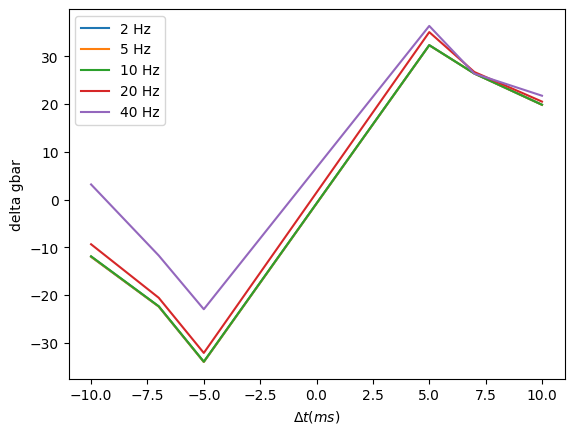

In [13]:
for frequency, data in data2.groupby(FREQUENCY):
    plt.plot(data[DT], data[DG], label=f'{frequency} Hz')
plt.legend()
plt.xlabel(DT)
# plt.ylabel(DG)
plt.gca().set_ylabel("delta gbar")